# Вырезание фона селфи 

## Описание

## Часть 1.Обучение нейронной сети

In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
import shutil
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from skimage.io import imread, imshow
from skimage.transform import resize
import warnings
warnings.filterwarnings('ignore')
from keras.models import Model, load_model
from keras.layers import Input, UpSampling2D
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import BatchNormalization, Activation, Dense, Dropout,UpSampling2D,Conv2DTranspose
from keras import backend as K
import keras
import tensorflow as tf
from PIL import Image

BATCH_SIZE = 16
IMG_CHANNELS = 3
num_train_samples = 28000
num_val_samples = 60000
train_batch_size = BATCH_SIZE
val_batch_size = BATCH_SIZE
train_steps = 1750
val_steps = 375
IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_CHANNELS = 3

In [ ]:
plt.figure(figsize=(7,7))
plt.tight_layout()
plt.axis('Off')
plt.subplot(1,2,1)
path = '../input/aisegmentcom-matting-human-datasets/clip_img/1803151818/clip_00000000/1803151818-00000003.jpg'
image = plt.imread(path)
plt.title('RGB Image')
plt.imshow(image)
plt.axis('off')
plt.subplot(1,2,2)
path = '../input/aisegmentcom-matting-human-datasets/matting/1803151818/matting_00000000/1803151818-00000003.png'
mask = plt.imread(path)
plt.title('RGBA Image')
plt.imshow(mask)
plt.axis('off')
plt.show()

In [ ]:
path = '../input/aisegmentcom-matting-human-datasets/clip_img/1803151818/clip_00000000/1803151818-00000003.jpg'
img=cv2.imread(path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
f = np.zeros((800,600,4),np.uint8)
f[:,:,:3] = img
f[:,:,3] = mask[:,:,3]*255
plt.imshow(f)
print(type(f[:,:,3]))

In [ ]:
c = pd.read_csv("../input/portraitsegmentation/mfinal.csv")

In [ ]:
def train_generator( df,batch_size=16, IMG_HEIGHT = 128, IMG_WIDTH = 128):
    while True:
        for  i in range(0,28000,16):
            X_train = np.zeros((batch_size, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
            Y_train = np.zeros((batch_size, IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float)
            for x in range(16):
                path = df["clip_paths"][x+i]
                image = cv2.imread(path)
                image = resize(image, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
                X_train[x] = image
                path = df["matted_paths"][x+i]
                mask = cv2.imread(path, cv2.IMREAD_UNCHANGED)
                k = mask[:, :, 3]
                k = np.expand_dims(k, axis=-1)
                k = resize(k, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
                k = k>0.5
                Y_train[x] = k
            yield X_train, Y_train

In [ ]:
def val_generator( df1,batch_size=16, IMG_HEIGHT = 128, IMG_WIDTH = 128):
    IMG_CHANNELS = 3
    while True:
        for  i in range(28000,34000,16):
            X_train = np.zeros((batch_size, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
            Y_train = np.zeros((batch_size, IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float)
            for x in range(16):
                path = df1["clip_paths"][x+i]
                image = cv2.imread(path)
                image = resize(image, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
                X_train[x] = image
                path =  df1["matted_paths"][x+i]
                mask = cv2.imread(path, cv2.IMREAD_UNCHANGED)
                k = mask[:, :, 3]
                k = np.expand_dims(k, axis=-1)
                k = resize(k, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
                k = k>0.5
                Y_train[x] = k
            yield X_train, Y_train

In [ ]:
def segnet():
    
    input1=Input((256,256,3))
    conv1=Conv2D(64,3,activation='relu',padding='same',kernel_initializer='he_normal')(input1)
    batch1=BatchNormalization()(conv1)
    conv2=Conv2D(64,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch1)
    c1=BatchNormalization()(conv2)
    drop1 = Dropout(0.1)(c1)
    pool1 =MaxPooling2D(pool_size=(2, 2))(drop1)    
    conv1=Conv2D(128,3,activation='relu',padding='same',kernel_initializer='he_normal')(pool1)
    batch1=BatchNormalization()(conv1)
    conv2=Conv2D(128,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch1)
    c2=BatchNormalization()(conv2)
    drop2 = Dropout(0.1)(c2)
    pool2 =MaxPooling2D(pool_size=(2, 2))(drop2) 
    conv1=Conv2D(256,3,activation='relu',padding='same',kernel_initializer='he_normal')(pool2)
    batch1=BatchNormalization()(conv1)
    conv2=Conv2D(256,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch1)
    batch2=BatchNormalization()(conv2)
    conv3=Conv2D(256,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch2)
    c3=BatchNormalization()(conv3)
    drop3 = Dropout(0.1)(c3)
    pool3 =MaxPooling2D(pool_size=(2, 2))(drop3) 
    conv1=Conv2D(512,3,activation='relu',padding='same',kernel_initializer='he_normal')(pool3)
    batch1=BatchNormalization()(conv1)
    conv2=Conv2D(512,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch1)
    batch2=BatchNormalization()(conv2)
    conv3=Conv2D(512,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch2)
    c4=BatchNormalization()(conv3)
    drop4 = Dropout(0.1)(c4)
    pool4 =MaxPooling2D(pool_size=(2, 2))(drop4) 
    conv1=Conv2D(1024,3,activation='relu',padding='same',kernel_initializer='he_normal')(pool4)
    batch1=BatchNormalization()(conv1)
    conv2=Conv2D(1024,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch1)
    batch2=BatchNormalization()(conv2)
    conv3=Conv2D(1024,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch2)
    c5=BatchNormalization()(conv3)
    drop5 = Dropout(0.1)(c5)
    pool5 =MaxPooling2D(pool_size=(2, 2))(drop5) 
    up1 =Conv2D(1024,2, activation = 'relu', padding = 'same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(pool5))
    merge1 = concatenate([c5,up1], axis =3)
    conv1=Conv2D(1024,3,activation='relu',padding='same',kernel_initializer='he_normal')(merge1)
    batch1=BatchNormalization()(conv1)
    conv2=Conv2D(1024,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch1)
    batch2=BatchNormalization()(conv2)
    conv3=Conv2D(1024,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch2)
    batch3=BatchNormalization()(conv3)
    batch3 = Dropout(0.2)(batch3)
    up2 =Conv2D(512,2, activation = 'relu', padding = 'same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(batch3))
    merge2 = concatenate([c4,up2], axis =3)
    conv1=Conv2D(512,3,activation='relu',padding='same',kernel_initializer='he_normal')(merge2)
    batch1=BatchNormalization()(conv1)
    conv2=Conv2D(512,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch1)
    batch2=BatchNormalization()(conv2)
    conv3=Conv2D(512,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch2)
    batch3=BatchNormalization()(conv3)
    batch3 = Dropout(0.2)(batch3)
    up3 =Conv2D(256,2, activation = 'relu', padding = 'same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(batch3))
    merge3 = concatenate([c3,up3], axis =3)
    conv1=Conv2D(256,3,activation='relu',padding='same',kernel_initializer='he_normal')(merge3)
    batch1=BatchNormalization()(conv1)
    conv2=Conv2D(256,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch1)
    batch2=BatchNormalization()(conv2)
    conv3=Conv2D(256,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch2)
    batch3=BatchNormalization()(conv3)
    batch3 = Dropout(0.2)(batch3)
    up4 =Conv2D(128,2, activation = 'relu', padding = 'same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(batch3))
    merge4 = concatenate([c2,up4], axis =3) 
    conv1=Conv2D(128,2,activation='relu',padding='same',kernel_initializer='he_normal')(merge4)
    batch1=BatchNormalization()(conv1)
    conv2=Conv2D(128,2,activation='relu',padding='same',kernel_initializer='he_normal')(batch1)
    batch2=BatchNormalization()(conv2)
    batch2 = Dropout(0.2)(batch2)
    up5 =Conv2D(64,1, activation = 'relu', padding = 'same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(batch2))
    merge5 = concatenate([c1,up5], axis =3) 
    conv1=Conv2D(64,3,activation='relu',padding='same',kernel_initializer='he_normal')(merge5)
    batch1=BatchNormalization()(conv1)
    conv2=Conv2D(64,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch1)
    batch2=BatchNormalization()(conv2)    
    output=Conv2D(1,(1,1),activation='sigmoid')(batch2)
    model=Model(input1,output)
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss=tf.keras.losses.BinaryCrossentropy(), metrics=["accuracy"])
    return model

In [ ]:
train_gen = train_generator(c,batch_size=BATCH_SIZE, IMG_HEIGHT = 256, IMG_WIDTH = 256)
val_gen = val_generator(c,batch_size=BATCH_SIZE, IMG_HEIGHT = 256, IMG_WIDTH = 256)
segnet_model=segnet()
history = segnet_model.fit_generator(train_gen, steps_per_epoch=train_steps, epochs=5,validation_data=val_gen, validation_steps=val_steps,verbose=1)

In [ ]:
segnet_model.save("model1.h5")

## Часть 2.Тест нейронной сети

In [ ]:
segnet_trained = load_model("/content/drive/MyDrive/model1.h5")

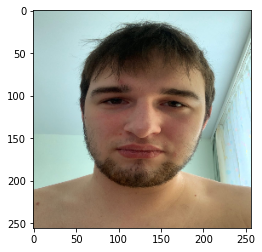

In [ ]:
path = "/content/drive/MyDrive/Me.jpg"
img= cv2.imread(path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img=cv2.resize(img,(256,256))
plt.imshow(img)
im = Image.fromarray(img)
im.save("/content/drive/MyDrive/input.jpg")

In [ ]:
def read_image(path):
    img=cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img=cv2.resize(img,(256,256))
    return img

In [ ]:
def prediction(path):
    img=read_image(path)
    img=img.reshape(1,256,256,3)
    pred=segnet_trained.predict(img)
    pred=pred.reshape(256,256)
    pre=pred>0.5
    pre=pre.astype(int)
    ind=np.where(pre==0)
    img=img.reshape((256,256,3))
    m=img.copy()
    m[ind[0],ind[1],:]=255
    return img,m

In [ ]:
a,b=prediction("/content/drive/MyDrive/Me.jpg")

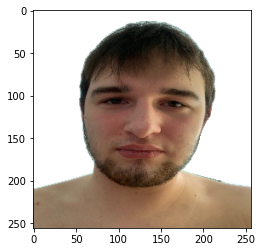

In [ ]:
plt.imshow(b)
from PIL import Image
im = Image.fromarray(b)
im.save("b.jpeg")